In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from mlxtend.classifier import StackingClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, recall_score, f1_score, precision_score

import eli5
from eli5.sklearn import PermutationImportance
%matplotlib inline
%config InlineBackend.figure_format = 'svg'  # 图片输出为矢量图，保证清晰度

Using TensorFlow backend.


### 导入数据+初始化+划分训练集测试集

In [109]:
data = pd.read_csv("./RNA_seq.csv")
dataT=np.array(data)
data=dataT.T
co=data[0]
data1=np.delete(data,0,axis=0)
data=data1
datadf= pd.DataFrame(data=data[0:,0:],columns=co)
datadf.head()
data=datadf
data= data.replace("NOTLC",value=0)
data= data.replace("LC",value=1)
X=data.drop(['Group'],axis=1)
y=data['Group']

In [166]:
column=X.columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X=sc.fit_transform(X)
# X=pd.DataFrame(data=X,columns=column)

In [167]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=None)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (878, 60660)
Test shape: (220, 60660)


### SHAP and LIME

In [6]:
import shap
plt.rcParams['axes.unicode_minus'] =False
shap.initjs()

In [56]:
from lime import lime_tabular

#### AdaBoost

In [104]:
ada=AdaBoostClassifier().fit(X_train,y_train)
ada_shap_explainer=shap.TreeExplainer(ada)
ada_shap_values=ada_shap_explainer.shap_values(X_test)
shap.summary_plot(ada_shap_values[1],X_test,max_display=10,show=False)
plt.title('AdaBoost')
plt.savefig('./image/summary_plot_ada.png', dpi=500, bbox_inches='tight',facecolor='white')

In [ ]:
import shap
import matplotlib.pyplot as plt
print("                                                                 (a)AdaBoost")
shap.force_plot(ada_shap_explainer.expected_value[1], ada_shap_values[1][10], X_test.iloc[10])

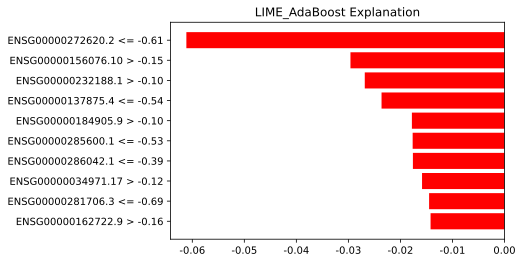

In [106]:
# 创建LIME解释器
ada_lime_explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=column.tolist(), class_names=['Negative', 'Positive'],discretize_continuous=True)

# 解释单个样本
exp = ada_lime_explainer.explain_instance(X_test[1], ada.predict_proba, num_features=10)
# 可视化展示
fig = exp.as_pyplot_figure()
plt.title('LIME_AdaBoost Explanation')
plt.savefig('./image/LIME_ada.png', dpi=500, bbox_inches='tight',facecolor='white') 
plt.show()

#### XGBoost

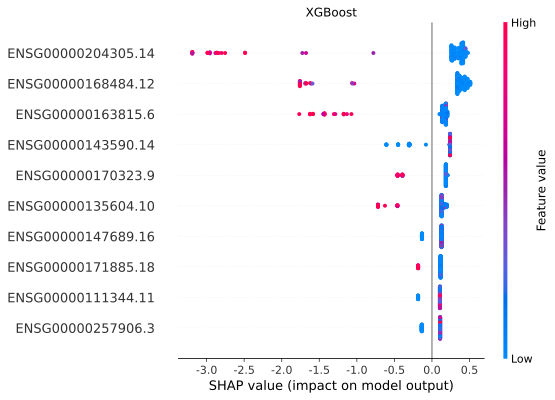

In [14]:
xgb=XGBClassifier().fit(X_train,y_train)
x_explainer=shap.TreeExplainer(xgb)
x_shap_values=x_explainer.shap_values(X_test)
shap.summary_plot(x_shap_values,X_test,max_display=10,show=False)
plt.title('XGBoost')
plt.savefig('./image/SHAP_xgb.png', dpi=500, bbox_inches='tight',facecolor='white')

In [163]:
print("                                                                 (b)XGBoost")
shap.force_plot(x_explainer.expected_value, x_shap_values[0], X_test.iloc[10])

                                                                 (b)XGBoost


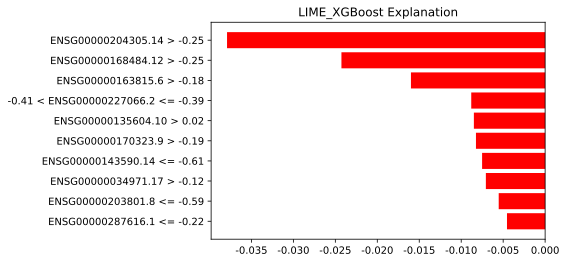

In [107]:
xgb_lime_explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=column.tolist(), class_names=['Negative', 'Positive'])
xgb=XGBClassifier().fit(X_train,y_train)
exp_clf5 = xgb_lime_explainer.explain_instance(X_test[1], xgb.predict_proba, num_features=10)
# 输出解释性结果
fig = exp_clf5.as_pyplot_figure()
plt.title('LIME_XGBoost Explanation')
plt.savefig('./image/LIME_xgb.png', dpi=500, bbox_inches='tight',facecolor='white') 
plt.show()

#### Random Forest

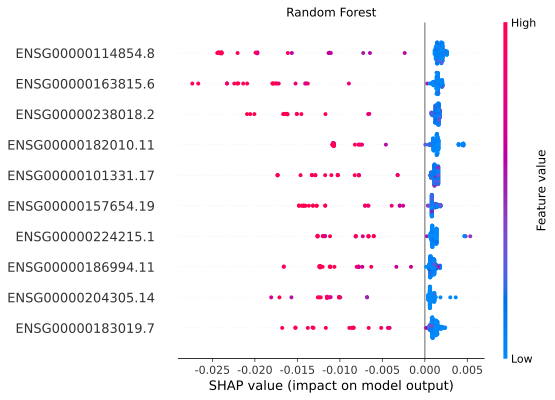

In [16]:
rf=RandomForestClassifier().fit(X_train,y_train)
rf_shap_explainer=shap.TreeExplainer(rf)
rf_shap_values=rf_shap_explainer.shap_values(X_test)
shap.summary_plot(rf_shap_values[1],X_test,max_display=10,show=False)
plt.title('Random Forest')
plt.savefig('./image/SHAP_RF.png', dpi=500, bbox_inches='tight',facecolor='white')

In [161]:
print("                                                                 (c)Random Forest")
shap.force_plot(rf_shap_explainer.expected_value[1], rf_shap_values[1][10], X_test.iloc[10])

                                                                 (c)Random Forest


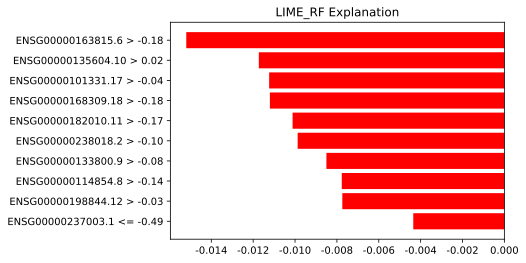

In [105]:
rf_lime_explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=column.tolist(), class_names=['Negative', 'Positive'])

# 解释单个样本
exp = rf_lime_explainer.explain_instance(X_test[1], rf.predict_proba, num_features=10)

# 可视化展示
fig = exp.as_pyplot_figure()
plt.title('LIME_RF Explanation')
plt.savefig('./image/LIME_RF.png', dpi=500, bbox_inches='tight',facecolor='white') 
plt.show()

#### Decision Tree

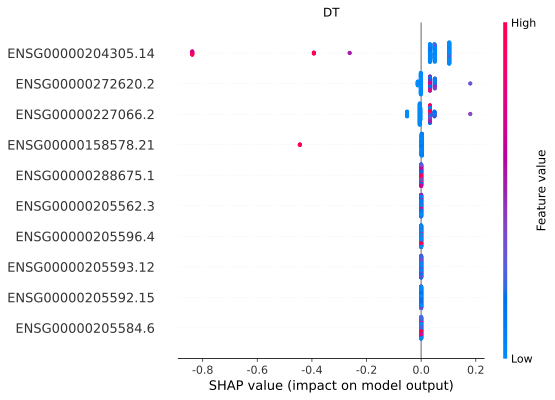

In [17]:
dt=DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=6).fit(X_train,y_train)
dt_shap_explainer=shap.TreeExplainer(dt)
dt_shap_values=dt_shap_explainer.shap_values(X_test)
shap.summary_plot(dt_shap_values[1],X_test,max_display=10,show=False)

plt.title('DT')
plt.savefig('./image/SHAP_DT.png', dpi=500, bbox_inches='tight',facecolor='white')

In [159]:
print("                                                                 (e)Decision Tree")
shap.force_plot(dt_shap_explainer.expected_value[1], dt_shap_values[1][10], X_test.iloc[10])

                                                                 (e)Decision Tree


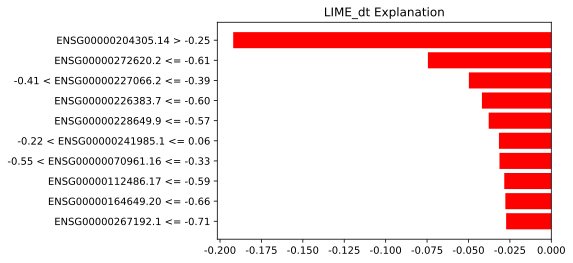

In [103]:
dt_lime_explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=column.tolist(), class_names=['Negative', 'Positive'])

# 解释单个样本
exp = dt_lime_explainer.explain_instance(X_test[1], dt.predict_proba, num_features=10)

# 可视化展示
fig = exp.as_pyplot_figure()
plt.title('LIME_dt Explanation')
plt.savefig('./image/LIME_dt.png', dpi=500, bbox_inches='tight',facecolor='white') 
plt.show()

#### Gaussian NB

In [40]:
# 计算解释值
# sample_index = 4  # 选择第5个样本
# GNB_shap_values = GNB_shap_explainer.shap_values(X_test.iloc[sample_index])
# #或者这种
# GNB_shap_values = GNB_shap_explainer.shap_values(X_test)
#都报错：Unable to allocate 45.7 TiB for an array with shape (117830, 53259480) and data type float64


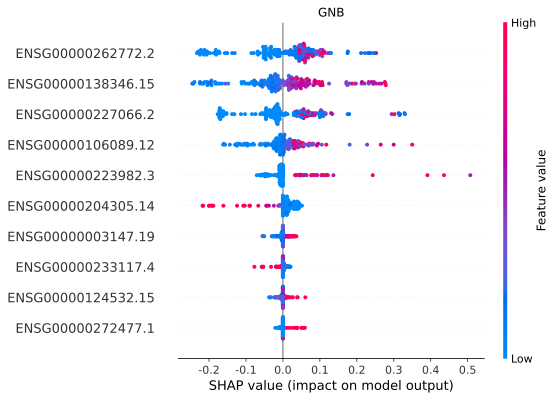

In [45]:
sel_seq_dt_mask=['ENSG00000003147.19','ENSG00000004455.17','ENSG00000006327.14','ENSG00000018510.17','ENSG00000067064.11','ENSG00000154813.10','ENSG00000204305.14','ENSG00000234425.1','ENSG00000262772.2','ENSG00000272477.1']
sel_seq_rf_mask=['ENSG00000106089.12', 'ENSG00000204305.14', 'ENSG00000223982.3','ENSG00000229693.2']
sel_seq_ada_mask=['ENSG00000000005.6', 'ENSG00000002933.9','ENSG00000019144.19', 'ENSG00000070366.14','ENSG00000091262.16','ENSG00000106089.12','ENSG00000204305.14','ENSG00000233117.4']
sel_seq_gnb_mask=['ENSG00000011052.21','ENSG00000052841.15','ENSG00000062194.16','ENSG00000068001.14','ENSG00000102871.16','ENSG00000124532.15', 'ENSG00000204305.14', 'ENSG00000227066.2']
sel_seq_xgb_mask=['ENSG00000106089.12','ENSG00000138346.15','ENSG00000204305.14']

feature=list(set(sel_seq_dt_mask+sel_seq_rf_mask+sel_seq_ada_mask+sel_seq_gnb_mask+sel_seq_xgb_mask))
gnb_feature=feature
X_train_gnb=X_train[gnb_feature]
X_test_gnb=X_test[gnb_feature]
GNB = GaussianNB()
GNB.fit(X_train_gnb,y_train)

# 创建KernelExplainer解释器
GNB_shap_explainer =shap.KernelExplainer(GNB.predict_proba, X_train_gnb)

# 计算SHAP值
GNB_shap_values = GNB_shap_explainer.shap_values(X_test_gnb)

# 生成摘要图
shap.summary_plot(GNB_shap_values[1], X_test_gnb, max_display=10, show=False)

# 保存摘要图为文件
import matplotlib.pyplot as plt
plt.title('GNB')
plt.savefig('./image/SHAP_GNB.png', dpi=500, bbox_inches='tight',facecolor='white')


In [160]:
X_test_gnb=X_test[gnb_feature]
print("                                                                 (d)Gaussian Naive Bayes")
shap.force_plot(GNB_shap_explainer.expected_value[1], GNB_shap_values[1][10], X_test_gnb.iloc[10])

                                                                 (d)Gaussian Naive Bayes


In [169]:
sc = StandardScaler()
X_train_gnb=sc.fit_transform(X_train_gnb)
X_test_gnb=sc.fit_transform(X_test_gnb)

In [70]:
X_gnb=X[gnb_feature]

In [81]:
column_gnb=column

In [75]:
sc = StandardScaler()
X_gnb=sc.fit_transform(X_gnb)

In [79]:
GNB.fit(X_train,y_train)

GaussianNB()

In [89]:
gnb=GaussianNB().fit(X_train_gnb,y_train)

In [76]:
X_train_gnb,X_test_gnb,y_train,y_test = train_test_split(X_gnb,y,test_size=0.2,random_state=42,stratify=None)

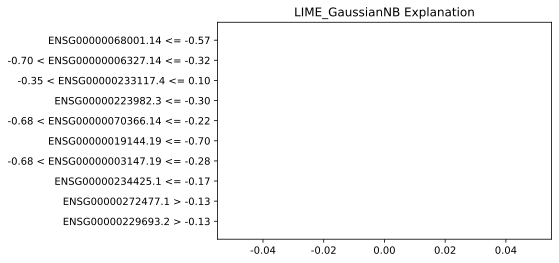

In [177]:
gnb_lime_explainer = lime_tabular.LimeTabularExplainer(X_train_gnb, feature_names=column_gnb.tolist(), class_names=['Negative', 'Positive'])

# 解释单个样本
exp = gnb_lime_explainer.explain_instance(X_test_gnb[1], gnb.predict_proba, num_features=10)

# 可视化展示
fig = exp.as_pyplot_figure()
plt.title('LIME_GaussianNB Explanation')
plt.savefig('./image/LIME_GaussianNB.png', dpi=500, bbox_inches='tight',facecolor='white') 
plt.show()

In [ ]:
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
import glob

# 获取所有需要拼接的图像路径
path = 'E:/lung_cancer_prediction/images/TCGA_RNAseq'  # 图片所在的目录路径
image_paths = glob.glob(path + '/LIME*.png')

rows=2
cols=3

# 读入第一张图像作为基准
base_image = Image.open(image_paths[0])

# 获取基准图像的尺寸
w,h = 4000,2200

passw=w/2
passh=2000

# 创建空白图像
result = Image.new('RGB', (w*cols,h*rows),color='white')

t="a"
text='(%s)'%(t)
draw = ImageDraw.Draw(result)
font_size = 100  
font = ImageFont.truetype('arial.ttf',font_size)

# 将所有图像拼接在一起
for i in range(rows):
    for j in range(cols):
        index = i*cols+j
        if index < len(image_paths):
            image = Image.open(image_paths[index])
            result.paste(image, (j*w, i*h))
            x=j*w+passw
            y=i*h+passh
            text='(%s)'%(t)
            draw.text((x,y),text,fill=(0,0,0),font=font)
            t=chr(ord(t) + 1)


# 显示结果
result.save('E:/lung_cancer_prediction/images/TCGA_RNAseq/LIME.jpg')
# result.show()